# Udacity Data Science Nanodegree 
## Capstone Project: Starbucks
Sandra Muschkorgel

Berlin, 27th June 2021

## Content
* <a href="#intro">Introduction</a>
* <a href="#assess">Data Assessment and Cleaning</a>
* <a href="#explore">Data Exploration</a>
* <a href="#preprocess">Data Preprocession</a>
* <a href="#model">Data Modeling</a>
  * <a href="#model1">Model 1</a>
  * <a href="#model2">Model 2</a>
  * Model 3
* <a href=""></a>
* <a href="#end">Conclusion</a>

***

<a id="intro"></a>
## Introduction

Domain introduction
* Starbucks dataset
* Goal: Identify which offer to send to which user
* 

Technical introduction
[...]

In [456]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

%matplotlib inline

In [2]:
profile = pd.read_json('data/profile.json', lines=True)
portfolio = pd.read_json('data/portfolio.json', lines=True)
transcript = pd.read_json('data/transcript.json', lines=True)

***
<a id="assess"></a>
## Data Assessment and Cleaning

**`profile`**

In [3]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [4]:
profile.shape

(17000, 5)

In [5]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [6]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [7]:
profile.isnull().sum()['gender'] / profile.shape[0]

0.12794117647058822

In [8]:
profile[profile.age == 118].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [9]:
profile[profile.age < 118].describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [10]:
profile[(profile.age > 80) & (profile.age < 118)]['income'].describe()

count       986.000000
mean      71787.018256
std       22318.990431
min       30000.000000
25%       55000.000000
50%       71000.000000
75%       88750.000000
max      120000.000000
Name: income, dtype: float64

In [11]:
profile.duplicated().sum()

0

In [12]:
profile.nunique()

gender                  3
age                    85
id                  17000
became_member_on     1716
income                 91
dtype: int64

In [13]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

**`portfolio`**

In [14]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [15]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


**`transcript`** 

In [16]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [17]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [18]:
transcript[transcript.person == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


In [19]:
transcript[transcript.event == 'offer received'].sample(5)

,person,event,value,time
162056,28e1cc20d9eb4e77ba81846057def62e,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},408
118613,acc0e0ced2c94365a02b8f2b7117d3b7,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},336
119101,a2062b74d1304d0ab3d870e819b14016,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},336
3521,d7a4c9a5d4394065af1af3f924877d5c,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
206508,1cbc184a0c1e4bb2b42ef19f6bd0d031,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504


In [20]:
transcript[transcript.event == 'offer viewed'].sample(5)

,person,event,value,time
19661,2587a4254c8744288dc5e472119a4274,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},12
169718,6a34efdf439f4ef3bc13bf6b81d7ae3c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},414
76741,085efb39e80140f08b90e0d77299958b,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},186
82965,4e5c30a071914472b24cbdf7c0d4f609,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},204
268098,3a1c0ab4be6740a19085d3d9c9685845,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},588


In [21]:
transcript[transcript.event == 'transaction'].sample(5)

,person,event,value,time
285826,9e2bfae4d1064d93968843fbdcbcc5be,transaction,{'amount': 0.27},630
93748,dbc3af1a46704027ad2da026c47a85ac,transaction,{'amount': 8.84},246
237528,dec189ccab874c059b32e2c6596c362d,transaction,{'amount': 10.71},552
301072,28b76b8d5fca4472843858b69a9ad5f3,transaction,{'amount': 0.4},690
36212,0b6c775f84a8435a9083900e1cb43ec9,transaction,{'amount': 0.13},72


In [22]:
transcript[transcript.event == 'offer completed'].sample(5)

,person,event,value,time
80752,c2a5c2407540466b9b0f7e8e50715a73,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,198
175854,37d27dc053ea481a94009b7e5ec92308,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,426
223028,5b9d0f58c558420fb1c34cf5256c6ea9,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,516
27873,f970eafddcb34154aa4d646b4a71ca34,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,42
226612,94d6d078828f4c719c414ffb5d423eda,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,522


Since there are missing entries in the ``profile`` dataframe, I will check whether transactions for these users exist.

In [23]:
incomplete_profiles = profile[profile.gender.isnull()]['id'].values
transcript_profiles = transcript.person.values

In [24]:
len(incomplete_profiles), len(np.intersect1d(incomplete_profiles, transcript_profiles))

(2175, 2175)

All users with incomplete records can be found in the ``transcript`` dataframe, i.e. have an action attached to them.
 
### Assessment summary

#### Data quality
`profile`
* Age 118 encodes missing values
* 2,175 missing entries in *gender*, *age* and *income* column
* Erronuous data types:
  * *gender* object &rarr; categorical
  * *became_member_on* int64 &rarr; datetime
  
`portfolio`
* *channels* combined in one column
* Erronuous data type: *offer_type* object &rarr; categorical

`transcript`
* Different keys in *value* column describing the same: offer id and offer_id

#### Tidiness
* `transcript` *value* column holds dictionaries 

### Data Cleaning

In [236]:
# Create copies for cleaned dataframes
profile_clean = profile.copy()
portfolio_clean = portfolio.copy()
transcript_clean = transcript.copy()

Before cleaning up each dataframe I will map the hashed user and offer ids to more readable versions.

In [237]:
def id_mapping(df, col):
    """
    Map hashed ids to more readable version.
    
    INPUT:
    df - dataframe 
    col - column containing the hashed ids
    
    OUTPUT:
    encoded - list containing the shortened ids
    mapping - dict containing all id pairs 
              key: hashed id (original), value: encoded id
    """
    
    mapping = {}
    counter = 1
    encoded = []
    
    for val in df[col]:
        if val not in mapping:
            mapping[val] = counter
            counter += 1
        
        encoded.append(mapping[val])
    return encoded, mapping

In [238]:
# Map person id in profile_clean
encoded_profile, mapping_profile = id_mapping(profile_clean, 'id')
profile_clean['person_id'] = encoded_profile

profile_clean.head()

,gender,age,id,became_member_on,income,person_id
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,3
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,4
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,5


Since the id column is no longer required, I will drop it.

In [239]:
profile_clean.drop('id', axis=1, inplace=True)

In [240]:
# Map offer id in portfolio_clean
encoded_portfolio, mapping_portfolio = id_mapping(portfolio_clean, 'id')
portfolio_clean['offer_id'] = encoded_portfolio

portfolio_clean

,reward,channels,difficulty,duration,offer_type,id,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,2
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,3
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,4
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,5
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,6
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,7
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,8
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,9
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,10


Since the id column is no longer required, I will drop it.

In [241]:
portfolio_clean.drop('id', axis=1, inplace=True)

In [242]:
# Map person id in transcript_clean
encoded_person = []
for val in transcript_clean['person']:
    encoded_person.append(mapping_profile[val])
    
transcript_clean['person_id'] = encoded_person
transcript_clean.drop('person', axis=1, inplace=True)
transcript_clean.head(10)

,event,value,time,person_id
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,4
1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,5
2,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,6
3,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,7
4,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,8
5,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,9
6,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,11
7,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,13
8,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,14
9,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,16


We cannot map the *value* column offer ids directly since they are stored as part of a dictionary. First, I need to transform the entire column. Then I will be able to extract the ids and map the offer ids to their corresponding encoded ids.

**`profile_clean`**

#### Missing values
* Age 118 encodes missing values
* 2,175 missing entries in *gender*, *age* and *income* column

##### Define
[...]

##### Code

In [243]:
profile_less = profile_clean.drop(profile_clean[profile_clean.gender.notnull()].index)
profile_clean.drop(profile_clean[profile_clean.gender.isnull()].index, inplace=True)

##### Test

In [244]:
profile_less.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            0 non-null      object 
 1   age               2175 non-null   int64  
 2   became_member_on  2175 non-null   int64  
 3   income            0 non-null      float64
 4   person_id         2175 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 102.0+ KB


In [245]:
profile_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   became_member_on  14825 non-null  int64  
 3   income            14825 non-null  float64
 4   person_id         14825 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 694.9+ KB


#### Erronuous data types

##### Define
Transform data types: *gender* object &rarr; categorical and *became_member_on* int64 &rarr; datetime.

##### Code

In [246]:
profile_clean['gender'] = profile_clean['gender'].astype('category')

In [247]:
profile_clean.became_member_on = profile_clean.became_member_on.astype(str)
profile_clean['member_year'] = profile_clean.became_member_on.str.slice(0, 4).astype(int)
profile_clean['member_month'] = profile_clean.became_member_on.str.slice(4, 6).astype(int)
profile_clean['member_day'] = profile_clean.became_member_on.str.slice(6, 8).astype(int)

In [248]:
# Drop became_member_on column
profile_clean.drop('became_member_on', axis=1, inplace=True)

##### Test

In [249]:
profile_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   gender        14825 non-null  category
 1   age           14825 non-null  int64   
 2   income        14825 non-null  float64 
 3   person_id     14825 non-null  int64   
 4   member_year   14825 non-null  int64   
 5   member_month  14825 non-null  int64   
 6   member_day    14825 non-null  int64   
dtypes: category(1), float64(1), int64(5)
memory usage: 825.3 KB


In [250]:
profile_clean.head()

,gender,age,income,person_id,member_year,member_month,member_day
1,F,55,112000.0,2,2017,7,15
3,F,75,100000.0,4,2017,5,9
5,M,68,70000.0,6,2018,4,26
8,M,65,53000.0,9,2018,2,9
12,M,58,51000.0,13,2017,11,11


**`portfolio_clean`**

#### *channels* combined in one column

##### Define 
Split *channels* into separate columns each representing one particular communication channel. Use 1 and 0 to indicate whether a channel was used for an offer or not.

##### Code

In [251]:
for i, val in enumerate(portfolio_clean['channels']):
    for channel in val:
        portfolio_clean.loc[i, channel] = 1

##### Test

In [252]:
portfolio_clean

,reward,channels,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,bogo,1,1.0,1.0,1.0,NaN
1,10,"[web, email, mobile, social]",10,5,bogo,2,1.0,1.0,1.0,1.0
2,0,"[web, email, mobile]",0,4,informational,3,1.0,1.0,NaN,1.0
3,5,"[web, email, mobile]",5,7,bogo,4,1.0,1.0,NaN,1.0
4,5,"[web, email]",20,10,discount,5,1.0,NaN,NaN,1.0
5,3,"[web, email, mobile, social]",7,7,discount,6,1.0,1.0,1.0,1.0
6,2,"[web, email, mobile, social]",10,10,discount,7,1.0,1.0,1.0,1.0
7,0,"[email, mobile, social]",0,3,informational,8,1.0,1.0,1.0,NaN
8,5,"[web, email, mobile, social]",5,5,bogo,9,1.0,1.0,1.0,1.0
9,2,"[web, email, mobile]",10,7,discount,10,1.0,1.0,NaN,1.0


In [253]:
# Drop channels column
portfolio_clean.drop('channels', axis=1, inplace=True)

#### Erronuous data type

##### Define
Transform data type: *offer_type* object &rarr; categorical.

##### Code

In [254]:
portfolio_clean['offer_type'] = portfolio_clean['offer_type'].astype('category')

##### Test

In [255]:
portfolio_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   reward      10 non-null     int64   
 1   difficulty  10 non-null     int64   
 2   duration    10 non-null     int64   
 3   offer_type  10 non-null     category
 4   offer_id    10 non-null     int64   
 5   email       10 non-null     float64 
 6   mobile      9 non-null      float64 
 7   social      6 non-null      float64 
 8   web         8 non-null      float64 
dtypes: category(1), float64(4), int64(4)
memory usage: 910.0 bytes


**`transcript`**

#### Different keys in *value* column describing the same: offer id and offer_id & Tidiness

##### Define
Separate the value column into three columns *offer_id*, *amount* and *reward*.

##### Code

In [256]:
# Extract values from dictionary in value column
tmp = pd.DataFrame(transcript_clean.value.values.tolist())

In [257]:
# Combine offer_id and offer id into one column
tmp.loc[tmp['offer id'].isnull(), 'offer id'] = tmp.loc[tmp['offer id'].isnull(), 'offer_id'].values
tmp.drop('offer_id', axis=1, inplace=True)

In [258]:
# Combine transcript_clean with the temporary df
transcript_clean = pd.concat([transcript_clean, tmp], axis=1)

In [259]:
# Map offer id to unhashed ids
encoded_offer = []
for val in transcript_clean['offer id']:
    if pd.isna(val):
        encoded_offer.append(np.nan)
    else:
        encoded_offer.append(mapping_portfolio[val])
    
transcript_clean['offer_id'] = encoded_offer
transcript_clean.drop('offer id', axis=1, inplace=True)

In [260]:
# Drop value column since it's no longer required
transcript_clean.drop('value', axis=1, inplace=True)

##### Test

In [261]:
transcript_clean.head(10)

,event,time,person_id,amount,reward,offer_id
0,offer received,0,4,NaN,NaN,4.0
1,offer received,0,5,NaN,NaN,5.0
2,offer received,0,6,NaN,NaN,10.0
3,offer received,0,7,NaN,NaN,7.0
4,offer received,0,8,NaN,NaN,2.0
5,offer received,0,9,NaN,NaN,9.0
6,offer received,0,11,NaN,NaN,6.0
7,offer received,0,13,NaN,NaN,3.0
8,offer received,0,14,NaN,NaN,5.0
9,offer received,0,16,NaN,NaN,5.0


***
<a id="explore"></a>
## Data Exploration
**``profile_clean``**

In [262]:
profile_clean.gender.value_counts() / profile_clean.shape[0]

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

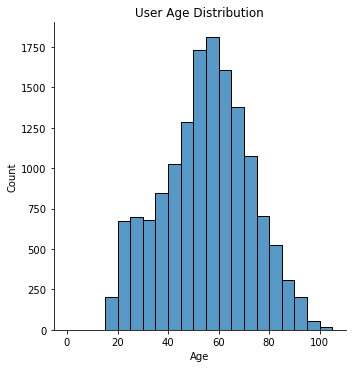

In [263]:
bins = np.arange(0, profile_clean.age.max()+5, 5)
sb.displot(profile_clean.age, bins=bins)
plt.title('User Age Distribution')
plt.xlabel('Age');

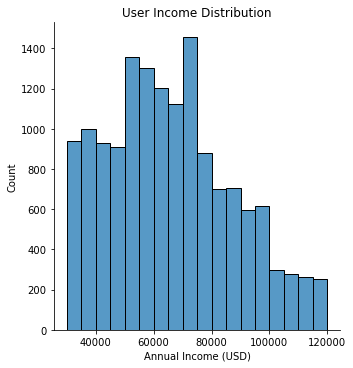

In [264]:
bins = np.arange(30000, profile_clean.income.max()+5000, 5000)
sb.displot(profile_clean.income, bins=bins)
plt.title('User Income Distribution')
plt.xlabel('Annual Income (USD)');

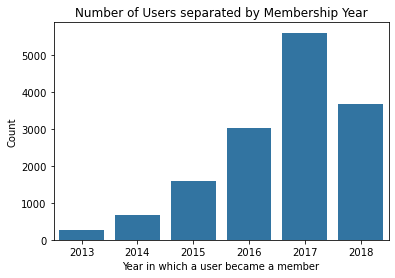

In [265]:
sb.countplot(data=profile_clean, x='member_year', color=sb.color_palette()[0])
plt.title('Number of Users separated by Membership Year')
plt.xlabel('Year in which a user became a member')
plt.ylabel('Count');

With a share of 57%, men represented the largest user group. 41% were women and only 1% belonged to the category *Other*. The user age roughly followed a normal distribution and was centered around 54 years. When looking at income buckets of USD 5,000 most users earned between USD 50,000 and USD 75,000. Beyond USD 75,000 annual salary the number of users per bucket gradually decreased. Another large user group belonged to the low income population earning between USD 30,000 and USD 50,000.

Most users became a Starbucks member in 2017. Between 2013 and 2016 the number of members signing up continuously increased. In 2018 Starbucks experienced a drop in new memberships.

In [266]:
profile_clean.groupby('gender')['age'].mean()

gender
F    57.544950
M    52.116690
O    54.400943
Name: age, dtype: float64

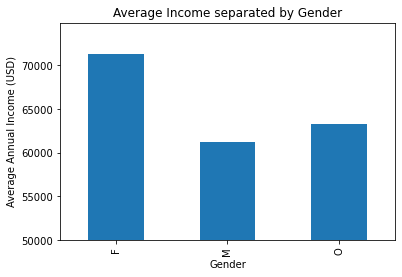

In [267]:
profile_clean.groupby('gender')['income'].mean().plot(kind='bar')
plt.ylim(50000, None)
plt.title('Average Income separated by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Annual Income (USD)');

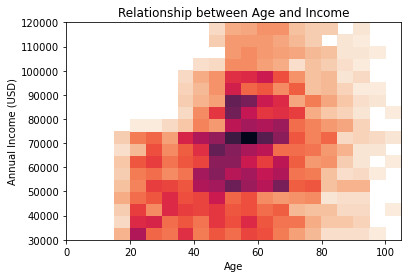

In [268]:
sample_size = 0.3 # If you choose 1 the entire dataset will be displayed
sample = profile_clean.sample(int(sample_size*profile_clean.shape[0]))
x_bins = np.arange(0, sample.age.max()+5, 5)
y_bins = np.arange(30000, sample.income.max()+5000, 5000)
plt.hist2d(x=sample['age'], y=sample['income'], cmin=0.5, cmap='rocket_r', bins=[x_bins, y_bins])
plt.title('Relationship between Age and Income')
plt.xlabel('Age')
plt.ylabel('Annual Income (USD)');

Women represented the oldest user group with an average of 57 years. The average male user was 5 years younger. Women earned more than USD 70,000 per year. Men on the other hand on average earned USD 10,000 less. There is no strong relationship between age and income. Users younger than 35 did not surpass the USD 80,000 salary threshold. Older users (70+ years) displayed incomes across the entire spectrum. There is a large cluster of users between 40 and 70 earning between USD 50,000 and USD 90,000.

**``portfolio_clean``**

In [269]:
portfolio_clean[portfolio_clean.offer_type == 'bogo']

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,1,1.0,1.0,1.0,NaN
1,10,10,5,bogo,2,1.0,1.0,1.0,1.0
3,5,5,7,bogo,4,1.0,1.0,NaN,1.0
8,5,5,5,bogo,9,1.0,1.0,1.0,1.0


In [270]:
portfolio_clean[portfolio_clean.offer_type == 'discount']

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
4,5,20,10,discount,5,1.0,NaN,NaN,1.0
5,3,7,7,discount,6,1.0,1.0,1.0,1.0
6,2,10,10,discount,7,1.0,1.0,1.0,1.0
9,2,10,7,discount,10,1.0,1.0,NaN,1.0


In [271]:
portfolio_clean[portfolio_clean.offer_type == 'informational']

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
2,0,0,4,informational,3,1.0,1.0,NaN,1.0
7,0,0,3,informational,8,1.0,1.0,1.0,NaN


When looking at each offer type individually the following can be observed:
* All offer types were sent out via email. With the exception of offer 5, which is the one with the highest difficulty, all offers were offered as a mobile version. The social and web channels were used more infrequently.
* Informational offers did not reward users and only lasted for 3 to 4 days.
* Per definition a bogo (= buy one get one free) always returned the same reward as was invested by the user (*difficulty*). They lasted either 5 or 7 days.
* Discount offers lasted either 7 or 10 days while offering lower rewards compared to bogos.
* There were several offer pairs which offered the same reward for the same upfront investment (*difficulty*) but lasted for different time periods: 1 and 2, 4 and 9, 7 and 10 (excluding informational offers).

**``transcript_clean``**

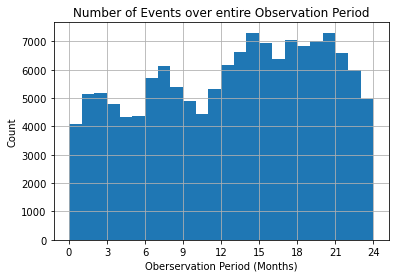

In [272]:
bins = np.arange(0, transcript_clean.time.max()+30, 30) # Monthly period
transcript_clean[transcript_clean.event == 'transaction']['time'].hist(bins=bins)
plt.title('Number of Events over entire Observation Period')
plt.xlabel('Oberservation Period (Months)')
plt.ylabel('Count')
ticks = np.arange(0, transcript_clean.time.max()+30, 90)
labels = ['{}'.format(int(v/30)) for v in ticks]
plt.xticks(ticks, labels);

In [273]:
transcript_clean[transcript_clean.time < 714 / 2]['event'].count() 

135224

In [274]:
transcript_clean[transcript_clean.time >= 714 / 2]['event'].count() 

171310

Events were recorded for a two year period. During the first year 135,224 events took place, compared to 171,310 events during the second year.

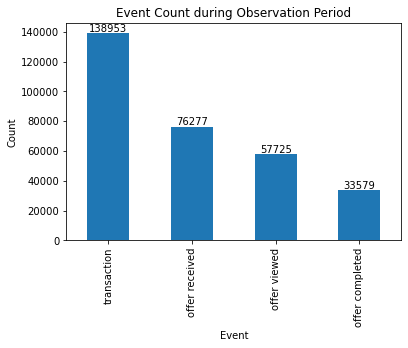

In [275]:
event_count = transcript_clean.event.value_counts()
event_count.plot(kind='bar')
plt.title('Event Count during Observation Period')
plt.xlabel('Event')
plt.ylabel('Count')
for i in np.arange(4):
    plt.text(x=i, y=event_count[i]+1000, s='{}'.format(event_count[i]), ha='center');

In [276]:
event_count[2] / event_count[1], event_count[3] / event_count[1]

(0.7567812053436815, 0.4402244451145168)

In total, almost 140,000 times users spent money on Starbucks. More than 76,000 offers were sent out, of which 76% were viewed and 44% were completed.

In [277]:
np.log10(transcript_clean.amount.describe())

count    5.142868
mean     1.106441
std      1.480733
min     -1.301030
25%      0.444045
50%      0.948902
75%      1.256958
max      3.026239
Name: amount, dtype: float64

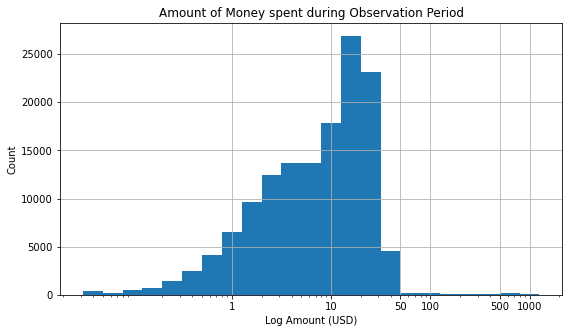

In [278]:
plt.figure(figsize=(9,5))
bins = 10 ** np.arange(-1.5, 3+0.2, 0.2)
transcript_clean[transcript_clean.event == 'transaction']['amount'].hist(bins=bins)

plt.title('Amount of Money spent during Observation Period')
plt.xlabel('Log Amount (USD)')
plt.ylabel('Count')
plt.xscale('log')
ticks = [1, 10, 50, 100, 500, 1000]
labels = ['{}'.format(v) for v in ticks]
plt.xticks(ticks, labels);

With regards to how much people spent per transaction a logarithmic distribution emerges. Most users spent around USD 10 to USD 25 on a transaction. Only very few users spent more than USD 50. There was a second large user group spending between less than USD 1 up to USD 10. 

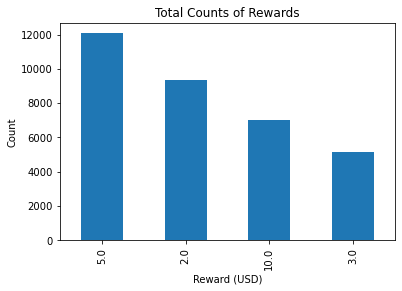

In [279]:
transcript_clean[transcript_clean.reward.notnull()]['reward'].value_counts().plot(kind='bar')
plt.title('Total Counts of Rewards')
plt.xlabel('Reward (USD)')
plt.ylabel('Count');

In terms of absolute numbers the USD 5 reward was handed out most of the time, followed by USD 2, USD 10 and finally USD 3 rewards (in descending order).

In [280]:
offers_sent = transcript_clean[transcript_clean.event == 'offer received']['offer_id'].value_counts()
offers_viewed = transcript_clean[transcript_clean.event == 'offer viewed']['offer_id'].value_counts()
success_rate_1 = transcript_clean[transcript_clean.reward.notnull()]['offer_id'].value_counts() / offers_sent
success_rate_2 = transcript_clean[transcript_clean.reward.notnull()]['offer_id'].value_counts() / offers_viewed

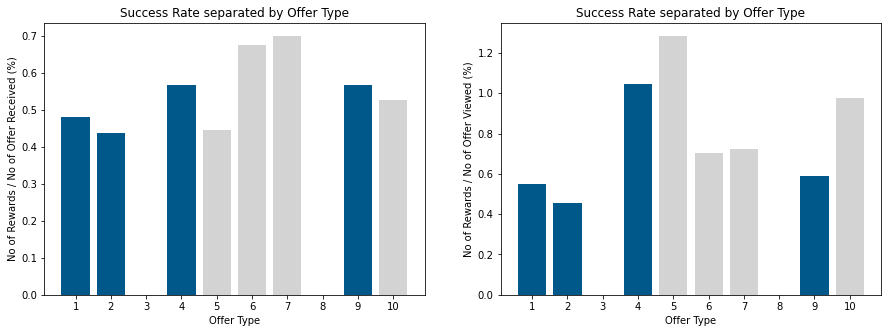

In [281]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.bar(success_rate_1.index, success_rate_1.values, color=['#00578a', '#00578a', 'white', '#00578a', 'lightgrey', 'lightgrey', 'lightgrey', 'white', '#00578a', 'lightgrey'])
plt.title('Success Rate separated by Offer Type')
plt.xlabel('Offer Type')
plt.ylabel('No of Rewards / No of Offer Received (%)')
ticks = np.arange(1, 11)
labels = ['{}'.format(v) for v in ticks]
plt.xticks(ticks, labels)

plt.subplot(1, 2, 2)
plt.bar(success_rate_2.index, success_rate_2.values, color=['#00578a', '#00578a', 'white', '#00578a', 'lightgrey', 'lightgrey', 'lightgrey', 'white', '#00578a', 'lightgrey'])
plt.title('Success Rate separated by Offer Type')
plt.xlabel('Offer Type')
plt.ylabel('No of Rewards / No of Offer Viewed (%)')
ticks = np.arange(1, 11)
labels = ['{}'.format(v) for v in ticks]
plt.xticks(ticks, labels);

[...] I defined the success rate as "the number of rewards per offer type divided by the number of times this offer was sent out". Bogos are indicated by blue bars, whereas discounts are grey. Offers 6 and 7 displayed the highest success rates Almost 70% of offers, which were sent out, were connected to a reward [...]

***

<a id="preprocess"></a>
## Data Preprocessing

### Definition of user categories

Definitions/Constraints:
* A user cannot view an offer he/she has not received.
* If a user has received a specific offer more than once and the offer was completed successfully at least once, the user-offer pair is defined as success.
* Completing an offer is defined as purchasing the offer in time to receive a reward. A purchase made when the offer period has already passed is not identified as a successful purchase.
* A successful purchase is defined as:
  * For informational offers (3 and 8):
    * NaN - A user who has not received an informational offer.
    * 0 - A user who has received an informational offer but did not view it.
    * 1 - A user who has received and viewed an informational offer. **SUCCESS**

  * For discount (5, 6, 7, 10) and bogo (1, 2, 4, 9) offers:
    * NaN - A user who has not received a discount or bogo offer.
    * 0 - A user who has received a discount or bogo offer, but did not view or complete it.
    * 0 - A user who has received and viewed a discount or bogo offer, but did not complete a purchase.
    * 0 - A user who has received a discount or bogo offer and completed a purchase, but did not view it. 
    * 0 - A user who has received a discount or bogo offer and completed a purchase, but did only view it after completing the purchase.
    * 1 - A user who has received, viewed and completed a purchase for a discount or bogo offer. **SUCCESS**

### Create a new dataframe 
The new dataframe contains the information from profile_clean (88% of all users had no missing values) and an entry for each offer about the success of an offer for a particular user.

In [355]:
def user_offer_dict(user_id):
    """
    Identify whether an offer was successful (1) or not (0) for a given user id.
    
    INPUT:
    user_id - id for a specific user
    
    OUTPUT:
    user_offer_dict - A dictionary with offer ids as keys and 0/1 as values
    """
    
    transactions = transcript_clean[transcript_clean.person_id == user_id]
    # Offers a user has received
    received = set(transactions[transactions.event == 'offer received']['offer_id'].values)

    user_offer_dict = {1.0:np.nan, 2.0:np.nan, 3.0:np.nan, 4.0:np.nan, 5.0:np.nan, 
                       6.0:np.nan, 7.0:np.nan, 8.0:np.nan, 9.0:np.nan, 10.0:np.nan}
    
    for offer in received:
        # Put all events associated with that offer id into a list
        event_order = transactions[transactions.offer_id == offer]['event'].values.tolist()

        if ((offer == 3.0) | (offer == 8.0)) & (len(event_order) == 2):
            user_offer_dict[offer] = 1
        elif (len(event_order) >= 3) & ('offer completed' in event_order) & ('offer viewed' in event_order):
            if (event_order.index('offer completed') - event_order.index('offer viewed') >= 0):
                user_offer_dict[offer] = 1
        else:
            user_offer_dict[offer] = 0
            
    return user_offer_dict

# BUG: Only looking for first appearances!

# BUG: Person 4 offer 9.0 does not show up in dictionary!

In [356]:
users = profile_clean.person_id.values
offers = np.arange(1.0, 11.0)

In [357]:
for user in users:
    user_dict = user_offer_dict(user)
    user_idx = profile_clean[profile_clean.person_id == user].index
    profile_clean.loc[user_idx, user_dict.keys()] = user_dict.values()

In [358]:
profile_clean

,gender,age,income,person_id,member_year,member_month,member_day,3.0,4.0,8.0,1.0,10.0,7.0,9.0,6.0,2.0,5.0
1,F,55,112000.0,2,2017,7,15,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F,75,100000.0,4,2017,5,9,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN
5,M,68,70000.0,6,2018,4,26,0,1,NaN,NaN,0,1,NaN,NaN,NaN,NaN
8,M,65,53000.0,9,2018,2,9,NaN,1,NaN,NaN,1,1,1,NaN,NaN,NaN
12,M,58,51000.0,13,2017,11,11,0,NaN,NaN,NaN,NaN,1,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,F,45,54000.0,16996,2018,6,4,NaN,NaN,1,NaN,NaN,NaN,NaN,0,0,NaN
16996,M,61,72000.0,16997,2018,7,13,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16997,M,49,73000.0,16998,2017,1,26,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0
16998,F,83,50000.0,16999,2016,3,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN


In [359]:
profile_clean.notnull().sum()

gender          14825
age             14825
income          14825
person_id       14825
member_year     14825
member_month    14825
member_day      14825
3.0              5524
4.0              4977
8.0              5517
1.0              5036
10.0             4957
7.0              5147
9.0              4935
6.0              5020
2.0              5122
5.0              5324
dtype: int64

***

<a id="model"></a>

## Data Modeling
<a id="model1"></a>
### Model 1

In [445]:
def get_offer_df(col):
    """Create sub df for one offer type.
    
    INPUT:
    col - one out of 10 offer types
    
    OUTPUT:
    sub_df - df containing no missing values for selected offer type
    """
    
    offers = np.arange(1., 11.).tolist()
    offers.remove(col)
    
    sub_df = profile_clean[profile_clean[col].notnull()]
    sub_df = sub_df.drop(offers, axis=1)
    sub_df[col] = sub_df[col].astype(int)
    
    return sub_df

In [450]:
def get_dummies_df(df, cat_cols=['gender']):
    """
    Create dummy variables for categorical columns.
    
    ARGUMENTS:
    df - dataframe to be transformed
    cat_cols - categorical columns
    
    RETURN VALUE:
    df - transformed dataframe
    """

    for col in cat_cols:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
        except:
            continue

    return df

In [521]:
def classifier_model(df, target_col, test_size=0.2, classifier=RandomForestClassifier()):
    """
    Create a classifier model fitted on a given training dataset.
    
    INPUT:
    df - dataframe containing all data
    target_col - target variable name
    test_size - size of test dataset (default 20%)
    classifier
    
    OUTPUT:
    clf - trained classifier
    X_test - test dataset with independent columns
    Y_test - test dataset with dependent (target) column
    """
    
    X = df.drop(['person_id', target_col], axis=1)
    Y = df[target_col]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    
    clf = classifier
    clf.fit(X_train, Y_train)
    
    return clf, X_test, Y_test

In [490]:
def evaluate_model(clf, X_test, Y_test):
    """
    Predict 
    
    INPUT:
    clf - trained classifier
    X_test - test dataset with independent columns
    Y_test - test dataset with dependent (target) column 
    
    OUTPUT:
    None
    """
    
    Y_pred = clf.predict(X_test)
    Y_pred_ = pd.DataFrame(Y_pred)
    Y_test_ = pd.DataFrame(Y_test)
    
    print(classification_report(Y_test_, Y_pred_) + '\n')

In [522]:
for offer in offers:
    df = get_offer_df(offer)
    df = get_dummies_df(df)
    clf, X_test, Y_test = classifier_model(df, offer)
    print(offer)
    evaluate_model(clf, X_test, Y_test)

1.0
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       526
           1       0.74      0.81      0.77       482

    accuracy                           0.77      1008
   macro avg       0.78      0.78      0.77      1008
weighted avg       0.78      0.77      0.77      1008


2.0
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       547
           1       0.75      0.88      0.81       478

    accuracy                           0.80      1025
   macro avg       0.81      0.81      0.80      1025
weighted avg       0.82      0.80      0.80      1025


3.0
              precision    recall  f1-score   support

           0       0.63      0.65      0.64       577
           1       0.60      0.58      0.59       528

    accuracy                           0.62      1105
   macro avg       0.62      0.62      0.62      1105
weighted avg       0.62      0.62      0.62      1105


4.0


### Additional features

In [502]:
for user in users:
    avg_amount = transcript_clean[transcript_clean.person_id == user].amount.mean()
    user_idx = profile_clean[profile_clean.person_id == user].index
    profile_clean.loc[user_idx, 'avg_amount'] = avg_amount

In [508]:
# Source: https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [509]:
count = 0
for i, user in enumerate(users):
    no_offers = transcript_clean[(transcript_clean.person_id == user) & (transcript_clean.event == 'offer received')]['event'].count()
    user_idx = profile_clean[profile_clean.person_id == user].index
    profile_clean.loc[user_idx, 'no_offers'] = no_offers
    update_progress(i / len(users))

Progress: [####################] 100.0%


In [519]:
profile_clean['avg_amount'] = profile_clean.avg_amount.fillna(0)

In [523]:
for offer in offers:
    df = get_offer_df(offer)
    df = get_dummies_df(df)
    clf, X_test, Y_test = classifier_model(df, offer)
    print(offer)
    evaluate_model(clf, X_test, Y_test)

1.0
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       526
           1       0.75      0.80      0.77       482

    accuracy                           0.77      1008
   macro avg       0.78      0.78      0.77      1008
weighted avg       0.78      0.77      0.77      1008


2.0
              precision    recall  f1-score   support

           0       0.89      0.75      0.81       547
           1       0.75      0.89      0.82       478

    accuracy                           0.81      1025
   macro avg       0.82      0.82      0.81      1025
weighted avg       0.83      0.81      0.81      1025


3.0
              precision    recall  f1-score   support

           0       0.62      0.65      0.64       577
           1       0.60      0.56      0.58       528

    accuracy                           0.61      1105
   macro avg       0.61      0.61      0.61      1105
weighted avg       0.61      0.61      0.61      1105


4.0


***
<a id="model2"></a>
### Model 2

In [540]:
go = (profile_clean[offers].sum() / profile_clean[offers].count()).to_frame().reset_index().rename(columns={0:'success_rate'})

In [541]:
pd.concat([portfolio_clean, go], axis=1)

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,index,success_rate
0,10,10,7,bogo,1,1.0,1.0,1.0,NaN,1.0,0.453733
1,10,10,5,bogo,2,1.0,1.0,1.0,1.0,2.0,0.471691
2,0,0,4,informational,3,1.0,1.0,NaN,1.0,3.0,0.476828
3,5,5,7,bogo,4,1.0,1.0,NaN,1.0,4.0,0.368093
4,5,20,10,discount,5,1.0,NaN,NaN,1.0,5.0,0.22314
5,3,7,7,discount,6,1.0,1.0,1.0,1.0,6.0,0.712151
6,2,10,10,discount,7,1.0,1.0,1.0,1.0,7.0,0.72994
7,0,0,3,informational,8,1.0,1.0,1.0,NaN,8.0,0.729563
8,5,5,5,bogo,9,1.0,1.0,1.0,1.0,9.0,0.602026
9,2,10,7,discount,10,1.0,1.0,NaN,1.0,10.0,0.365544


In [211]:
# Create user item matrix for event offer_received
received = transcript_clean[transcript_clean.event == 'offer received'].groupby(['person_id', 'offer_id'])['offer_id'].any().unstack().fillna(0).astype(int)

In [212]:
# Create user item matrix for event offer_received
viewed = transcript_clean[transcript_clean.event == 'offer viewed'].groupby(['person_id', 'offer_id'])['offer_id'].any().unstack().fillna(0).astype(int)

In [213]:
# Create user item matrix for event offer_received
completed = transcript_clean[transcript_clean.event == 'transaction']#.groupby(['person_id', 'amount'])['amount'].any().unstack().fillna(0).astype(int)